
# EDA — Casos de Dengue em Campinas (Parte 1 do Projeto)

**Integrantes:** Felipe Adriano, Frank, Thiago Aguiar  
**Objetivo desta entrega:** Entendimento do problema, descrição do dataset e tópicos relacionados a primeira entrega.  



## 1) Problema & Motivação (≈½ página)
- **Tema:** Monitoramento e análise exploratória de **dengue na cidade de Campinas**.
- **Motivação:** Diante dos recentes casos de dengue em Campinas e do impacto na rede de saúde, buscamos gerar evidências objetivas para mapear sazonalidade, localizar áreas prioritárias e perfis de risco, e apoiar a alocação de recursos e ações de controle do vetor.
- **Objetivo:** Explorar o(s) dataset(s) de dengue para responder perguntas-chave sobre tempo, espaço e perfil dos casos.
- **Escopo (Parte 1):** Limpeza inicial, EDA com perguntas/hipóteses e visualizações; **modelagem** e validação ficam para a **Parte 2**.


## 2) Dataset(s) — Descrição e Fonte
**Link da(s) fonte(s):** [`Arboviroses — Dengue (dados.gov.br)`](https://dados.gov.br/dados/conjuntos-dados/arboviroses-dengue)  
**Unidade de análise:** cada linha representa uma notificação/caso no SINAN.  
**Período coberto:** conforme arquivo baixado (ex.: 2015–2025); neste projeto, foco em 2025.  
**Dicionário de dados (principais colunas e mapeamentos):**
- `data_notificacao` (date) — SINAN: `DT_NOTIFIC`
- `data_inicio_sintomas` (date) — SINAN: `DT_SIN_PRI`
- `sexo` (string) — SINAN: `CS_SEXO` (mapeado para Feminino/Masculino/Ignorado)
- `idade` (float, anos) — derivada de `NU_IDADE_N` (1xxx=anos; 2xxx=meses; 3xxx=dias; 4xxx=horas)
- `classificacao_final` (string) — SINAN: `CLASSI_FIN` (10=Dengue; 11=Alarme; 12=Grave; 8=Descartado/Inconclusivo)
- `evolucao` (string) — SINAN: `EVOLUCAO` (ex.: Cura; Óbito por dengue; Outras causas)

In [ ]:

# 3) Setup
# Fixar aleatoriedade/reprodutibilidade quando necessário
RANDOM_STATE = 42

import os
import sys
import math
import json
import textwrap
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# Funções auxiliares simples
def percent(x, base):
    return 100.0 * (x / base) if base else np.nan

def parse_dates(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce", dayfirst=True)
    return df



## 4) Carregamento dos dados

In [ ]:

# 4) Carregamento — SINAN Dengue (Campinas 2025)
# Caminho relativo a partir deste notebook (coloque o arquivo em ./data)
DATA_FILE = Path("DENGBR25_MUNICIP_RESI_MODELO.xlsx")

if not DATA_FILE.exists():
    raise FileNotFoundError(f"Arquivo de dados não encontrado. Coloque em {DATA_FILE}")

# Leitura do Excel (pandas escolhe engine adequado)
df_raw = pd.read_excel(DATA_FILE)

# Parse de datas (dayfirst=True)
for col in ["DT_SIN_PRI", "DT_NOTIFIC"]:
    if col in df_raw.columns:
        df_raw[col] = pd.to_datetime(df_raw[col], errors="coerce", dayfirst=True)

# Checagens de cobertura nas colunas-chave
cols_check = [
    "DT_SIN_PRI", "DT_NOTIFIC", "NU_IDADE_N", "CS_SEXO", "CLASSI_FIN", "EVOLUCAO"
]
print("Shape (arquivo completo):", df_raw.shape)
for c in cols_check:
    if c in df_raw.columns:
        cov = percent(df_raw[c].notna().sum(), len(df_raw))
        print(f"Cobertura de {c}: {cov:.1f}%")
    else:
        print(f"Coluna ausente no arquivo: {c}")

# Mantém apenas linhas com DT_SIN_PRI válido para séries mensais e filtra ano 2025
if "DT_SIN_PRI" in df_raw.columns:
    df = df_raw[df_raw["DT_SIN_PRI"].notna()].copy()
    df = df[df["DT_SIN_PRI"].dt.year == 2025].copy()
else:
    df = df_raw.copy()

print("Shape (2025 com DT_SIN_PRI válido):", df.shape)


Shape (arquivo completo): (21737, 121)
Cobertura de DT_SIN_PRI: 100.0%
Cobertura de DT_NOTIFIC: 100.0%
Cobertura de NU_IDADE_N: 100.0%
Cobertura de CS_SEXO: 100.0%
Cobertura de CLASSI_FIN: 100.0%
Cobertura de EVOLUCAO: 99.5%
Shape (2025 com DT_SIN_PRI válido): (21672, 121)



## 5) Limpeza inicial
Itens mínimos: tipos corretos, duplicatas, valores faltantes, outliers (se fizer sentido).


In [ ]:

# Tipos
df.info()

# Duplicatas
dups = df.duplicated().sum()
print("Duplicatas:", dups)
if dups:
    df = df.drop_duplicates()

# Valores faltantes
na_counts = df.isna().sum().sort_values(ascending=False)
na_counts.head(20)


<class 'pandas.core.frame.DataFrame'>
Index: 21672 entries, 3 to 21736
Columns: 121 entries, TP_NOT to MIGRADO_W
dtypes: datetime64[ns](10), float64(93), int64(16), object(2)
memory usage: 20.2+ MB
Duplicatas: 1


,0
DT_CHIK_S2,21671
DT_PRNT,21671
DT_CHIK_S1,21671
PLASMATICO,21671
LACO_N,21671
SANGRAM,21671
HEMATURA,21671
PETEQUIAS,21671
METRO,21671
GENGIVO,21671


In [ ]:

# Regras simples de limpeza — AJUSTE para seu contexto
# Ex.: remover linhas sem data de notificação; padronizar strings; tratar idades inválidas

if "data_notificacao" in df.columns:
    df = df[~df["data_notificacao"].isna()]

for c in ["bairro", "distrito", "classificacao_final", "sexo"]:
    if c in df.columns and df[c].dtype == "O":
        df[c] = df[c].str.strip().str.upper()

if "idade" in df.columns:
    # Idades negativas ou absurdas viram NaN e depois podemos imputar/descartar
    df.loc[(df["idade"] < 0) | (df["idade"] > 110), "idade"] = np.nan

df_clean = df.copy()
df_clean.shape


(21671, 121)

In [ ]:

# 5) Derivações e normalizações

# Funções utilitárias
CLASSI_MAP = {10: "Dengue", 11: "Dengue c/ sinais de alarme", 12: "Dengue grave", 8: "Descartado/Inconclusivo"}
EVOL_MAP = {1: "Cura", 2: "Óbito por dengue", 3: "Óbito por outras causas", 9: "Ignorado"}
SEXO_MAP = {"F": "Feminino", "M": "Masculino", "I": "Ignorado"}

# Conversão NU_IDADE_N → idade em anos
# Regras: 1xxx=anos, 2xxx=meses, 3xxx=dias, 4xxx=horas

def convert_idade_to_anos(v):
    if pd.isna(v):
        return np.nan
    try:
        v = int(v)
    except Exception:
        return np.nan
    escala = v // 1000
    valor = v % 1000
    if escala == 1:
        return float(valor)
    if escala == 2:
        return float(valor) / 12.0
    if escala == 3:
        return float(valor) / 365.0
    if escala == 4:
        return float(valor) / (365.0 * 24.0)
    return np.nan

# Faixas etárias
FAIXAS = [0, 5, 10, 15, 20, 40, 60, np.inf]
FAIXAS_LABELS = ["0-4", "5-9", "10-14", "15-19", "20-39", "40-59", "60+"]

# Derivações
if len(df) > 0:
    df["data_ref"] = df["DT_SIN_PRI"]
    df["mes"] = df["data_ref"].dt.month
    # Estação (Hemisfério Sul)
    def month_to_estacao(m):
        if m in [12, 1, 2]:
            return "Verão"
        if m in [3, 4, 5]:
            return "Outono"
        if m in [6, 7, 8]:
            return "Inverno"
        return "Primavera"
    df["estacao"] = df["mes"].apply(month_to_estacao)

    # Idade em anos e faixa
    if "NU_IDADE_N" in df.columns:
        df["idade_anos"] = df["NU_IDADE_N"].apply(convert_idade_to_anos)
        df["faixa_etaria"] = pd.cut(df["idade_anos"], bins=FAIXAS, labels=FAIXAS_LABELS, right=False)

    # Mapas de descrição
    if "CLASSI_FIN" in df.columns:
        df["classi_desc"] = df["CLASSI_FIN"].map(CLASSI_MAP).fillna("Outros/NA")
    if "EVOLUCAO" in df.columns:
        df["evol_desc"] = df["EVOLUCAO"].map(EVOL_MAP).fillna("Outros/NA")
    if "CS_SEXO" in df.columns:
        df["sexo_desc"] = df["CS_SEXO"].map(SEXO_MAP).fillna("Outros/NA")

    # Atraso em dias (se possível)
    if {"DT_NOTIFIC", "DT_SIN_PRI"}.issubset(df.columns):
        mask = df["DT_NOTIFIC"].notna() & df["DT_SIN_PRI"].notna()
        df.loc[mask, "atraso_dias"] = (df.loc[mask, "DT_NOTIFIC"] - df.loc[mask, "DT_SIN_PRI"]).dt.days.astype(float)

# Mostrar visão compacta
cols_view = [
    "data_ref", "mes", "estacao", "idade_anos", "faixa_etaria", "classi_desc", "evol_desc", "atraso_dias", "CS_SEXO"
]
print("Colunas derivadas presentes:", [c for c in cols_view if c in df.columns])
print(df[cols_view].head(10))

# Harmonização para seções 6.x (df_clean com nomes genéricos)
# Gera colunas genéricas a partir dos códigos do SINAN, quando existirem

df_clean = df.copy()
if "DT_NOTIFIC" in df.columns:
    df_clean["data_notificacao"] = df["DT_NOTIFIC"]
if "DT_SIN_PRI" in df.columns:
    df_clean["data_inicio_sintomas"] = df["DT_SIN_PRI"]
if "NU_IDADE_N" in df.columns:
    df_clean["idade"] = df["NU_IDADE_N"].apply(convert_idade_to_anos)
if "CS_SEXO" in df.columns:
    df_clean["sexo"] = df["CS_SEXO"].map(SEXO_MAP).fillna(df["CS_SEXO"])  # mantém original quando não mapeado
if "CLASSI_FIN" in df.columns:
    df_clean["classificacao_final"] = df["CLASSI_FIN"].map(CLASSI_MAP).fillna("Outros/NA")


Colunas derivadas presentes: ['data_ref', 'mes', 'estacao', 'idade_anos', 'faixa_etaria', 'classi_desc', 'evol_desc', 'atraso_dias', 'CS_SEXO']
     data_ref  mes estacao  idade_anos faixa_etaria classi_desc evol_desc  atraso_dias CS_SEXO
3  2025-01-01    1   Verão    0.002511          0-4      Dengue      Cura          0.0       F
8  2025-01-01    1   Verão    0.007763          0-4      Dengue      Cura          1.0       F
14 2025-01-01    1   Verão    0.002968          0-4      Dengue      Cura          1.0       M
16 2025-01-01    1   Verão    0.002169          0-4      Dengue      Cura          1.0       F
17 2025-01-01    1   Verão    0.005936          0-4      Dengue      Cura          1.0       M
21 2025-01-03    1   Verão    0.003425          0-4      Dengue      Cura          0.0       F
24 2025-01-01    1   Verão    0.004680          0-4      Dengue      Cura          2.0       M
27 2025-01-02    1   Verão    0.003995          0-4      Dengue      Cura          1.0       F
2

In [ ]:

# 6) Tabelas base (Campinas 2025)
assert "mes" in df.columns, "Coluna 'mes' ausente. Verifique o carregamento/derivações."

# Casos por mês
casos_mes = df.groupby("mes").size().reindex(range(1,13), fill_value=0)
participacao_mes = (casos_mes / casos_mes.sum() * 100.0).round(2)

# Casos por estação e razão Verão/Inverno
casos_estacao = df.groupby("estacao").size().reindex(["Verão","Outono","Inverno","Primavera"], fill_value=0)
verao = casos_estacao.get("Verão", 0)
inverno = casos_estacao.get("Inverno", 1)  # evita divisão por zero
razao_verao_inverno = (verao / inverno) if inverno else np.nan

# Faixa etária (ano todo)
if "faixa_etaria" in df.columns:
    faixa_ano = df["faixa_etaria"].value_counts().reindex(FAIXAS_LABELS, fill_value=0)
else:
    faixa_ano = pd.Series(dtype=int)

# Faixa x mês
if "faixa_etaria" in df.columns:
    faixa_x_mes = (df.pivot_table(index="faixa_etaria", columns="mes", values="CS_SEXO", aggfunc="count")
                     .reindex(index=FAIXAS_LABELS, columns=range(1,13), fill_value=0))
else:
    faixa_x_mes = pd.DataFrame()

# Classificação por mês
if "classi_desc" in df.columns:
    classi_x_mes = (df.pivot_table(index="classi_desc", columns="mes", values="CS_SEXO", aggfunc="count")
                      .reindex(columns=range(1,13), fill_value=0))
else:
    classi_x_mes = pd.DataFrame()

# Óbitos por mês e CFR
is_obito = df.get("EVOLUCAO").eq(2) if "EVOLUCAO" in df.columns else pd.Series(False, index=df.index)
obitos_mes = df.loc[is_obito].groupby("mes").size().reindex(range(1,13), fill_value=0)

is_confirmado = df.get("CLASSI_FIN").isin([10,11,12]) if "CLASSI_FIN" in df.columns else pd.Series(False, index=df.index)
confirmados_mes = df.loc[is_confirmado].groupby("mes").size().reindex(range(1,13), fill_value=0)

CFR_mes = (obitos_mes / confirmados_mes.replace(0, np.nan))
CFR_mes_1000 = (CFR_mes * 1000).round(2)

# (Opcional) atraso por mês/estação
if "atraso_dias" in df.columns:
    atraso_mes = df.groupby("mes")["atraso_dias"].agg(["median", "quantile"]).copy()
    # quantile default é 0.5; para IQR, calculamos manualmente
    q1 = df.groupby("mes")["atraso_dias"].quantile(0.25)
    q3 = df.groupby("mes")["atraso_dias"].quantile(0.75)
    atraso_mes["IQR"] = (q3 - q1)

    atraso_estacao = df.groupby("estacao")["atraso_dias"].apply(lambda s: pd.Series({
        "median": s.median(),
        "IQR": s.quantile(0.75) - s.quantile(0.25)
    }))
else:
    atraso_mes = pd.DataFrame()
    atraso_estacao = pd.DataFrame()

print("Resumo base construído:")
print({
    "total_ano": int(casos_mes.sum()),
    "top_mes": int(casos_mes.idxmax()) if casos_mes.sum() else None,
    "verao": int(verao),
    "inverno": int(inverno if isinstance(inverno, (int,float)) else 0),
})



Resumo base construído:
{'total_ano': 21671, 'top_mes': 3, 'verao': 6012, 'inverno': 0}


/tmp/ipython-input-2954471462.py:22: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  faixa_x_mes = (df.pivot_table(index="faixa_etaria", columns="mes", values="CS_SEXO", aggfunc="count")


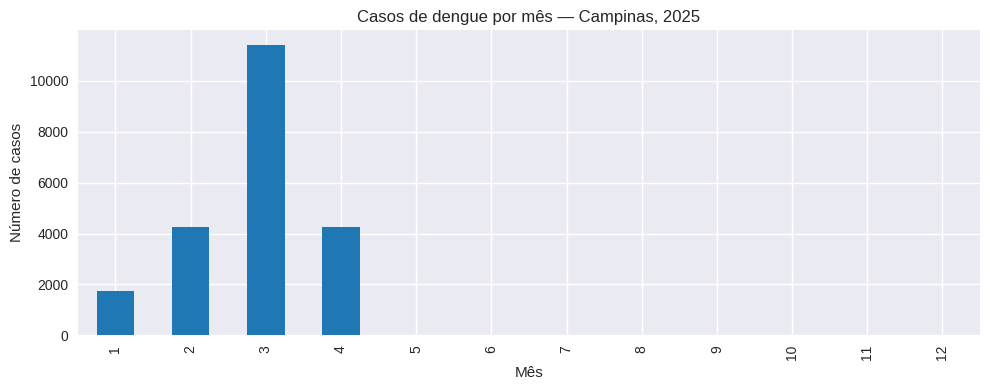

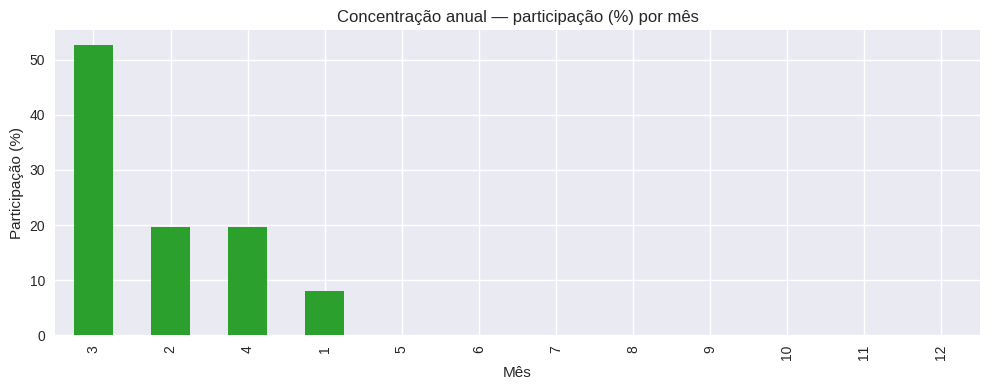

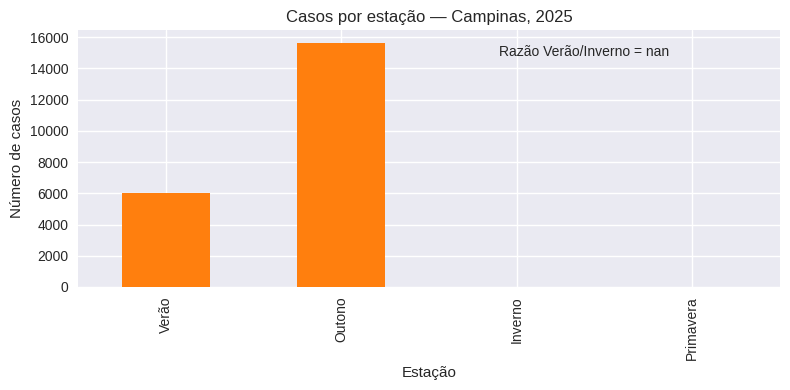

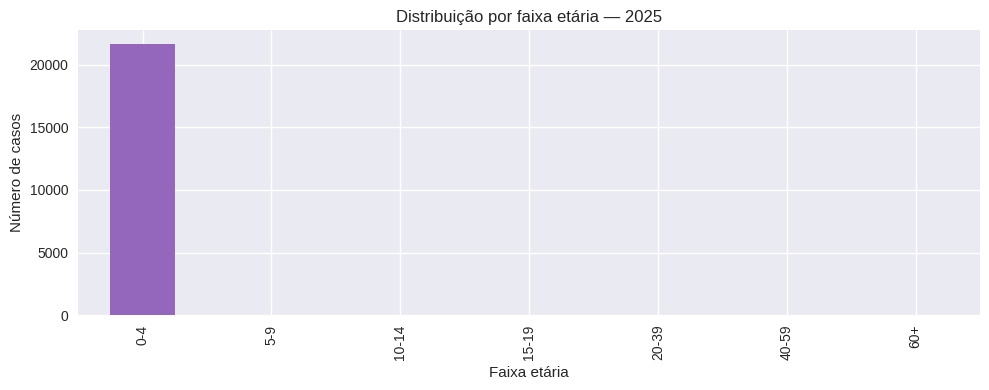

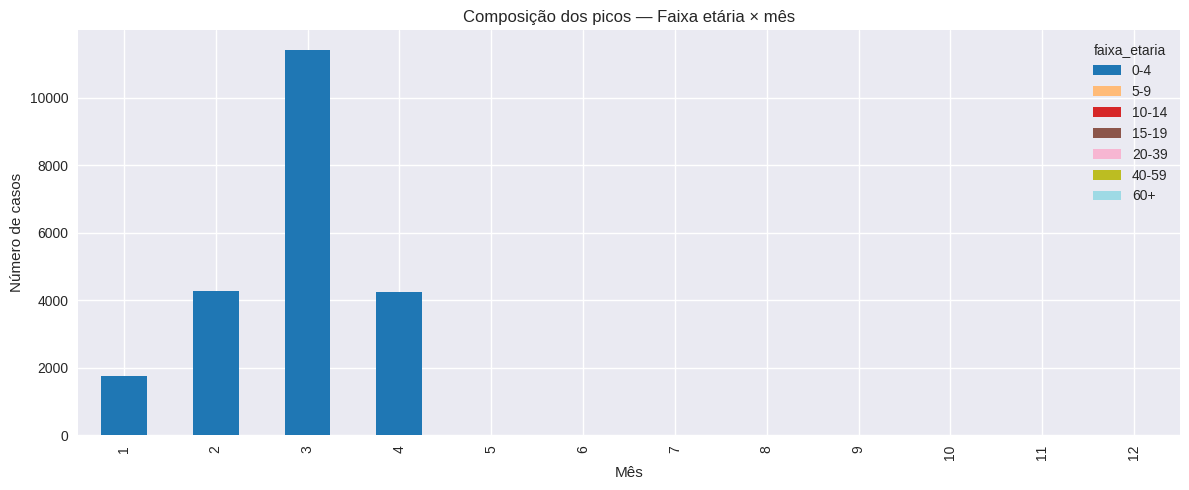

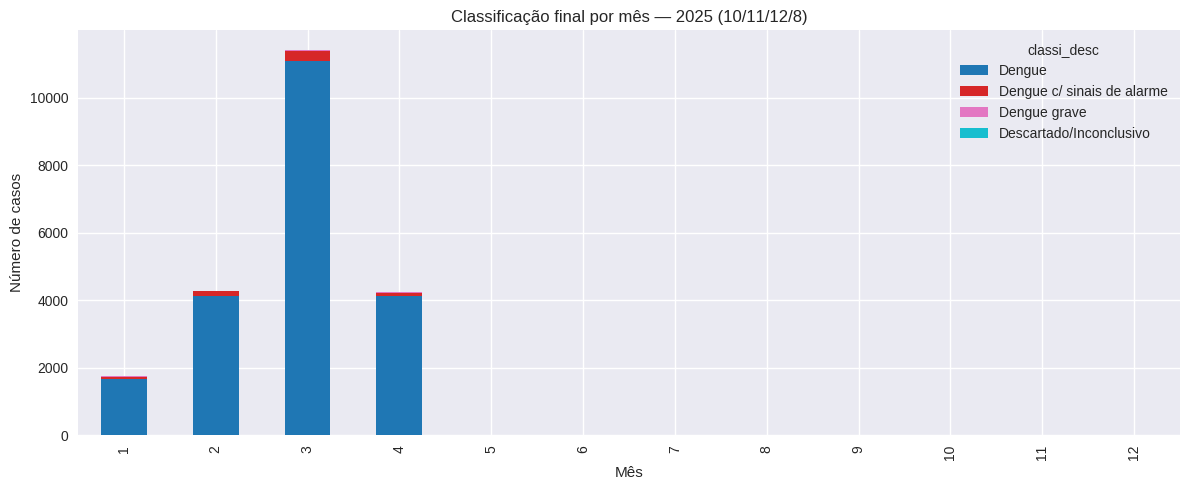

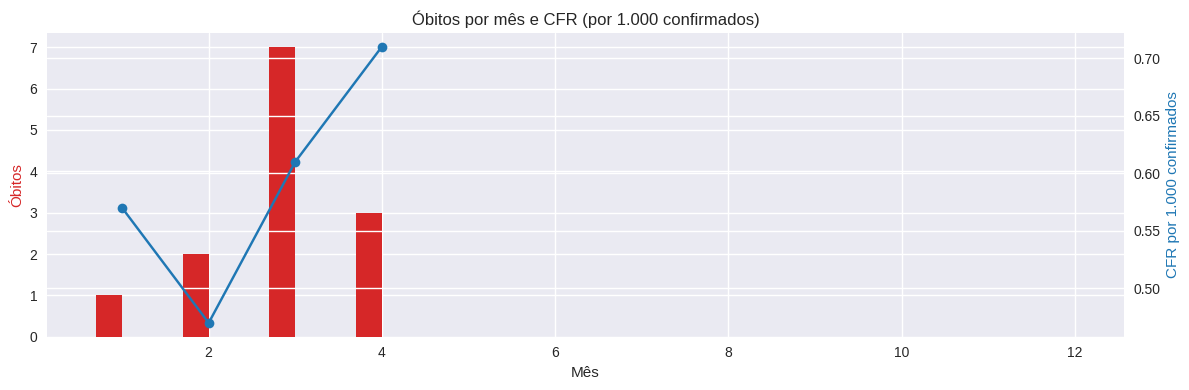

In [ ]:

# 7) Figuras nucleares
plt.style.use("seaborn-v0_8")

# 7.1 Casos de dengue por mês — Campinas, 2025
ax = casos_mes.plot(kind="bar", figsize=(10,4), color="#1f77b4")
ax.set_title("Casos de dengue por mês — Campinas, 2025")
ax.set_xlabel("Mês"); ax.set_ylabel("Número de casos")
plt.tight_layout(); plt.show()

# 7.2 Concentração anual — participação (%) por mês
ax = participacao_mes.sort_values(ascending=False).plot(kind="bar", figsize=(10,4), color="#2ca02c")
ax.set_title("Concentração anual — participação (%) por mês")
ax.set_xlabel("Mês"); ax.set_ylabel("Participação (%)")
plt.tight_layout(); plt.show()

# 7.3 Casos por estação — Campinas, 2025 (com anotação da razão)
ax = casos_estacao.plot(kind="bar", figsize=(8,4), color="#ff7f0e")
ax.set_title("Casos por estação — Campinas, 2025")
ax.set_xlabel("Estação"); ax.set_ylabel("Número de casos")
# anotação
ax.annotate(f"Razão Verão/Inverno = {razao_verao_inverno:.2f}", xy=(0.6, 0.9), xycoords='axes fraction')
plt.tight_layout(); plt.show()

# 7.4 Distribuição por faixa etária — 2025
if not faixa_ano.empty:
    ax = faixa_ano.plot(kind="bar", figsize=(10,4), color="#9467bd")
    ax.set_title("Distribuição por faixa etária — 2025")
    ax.set_xlabel("Faixa etária"); ax.set_ylabel("Número de casos")
    plt.tight_layout(); plt.show()

# 7.5 Composição dos picos — Faixa etária × mês
if not faixa_x_mes.empty:
    ax = faixa_x_mes.T.plot(kind="bar", stacked=True, figsize=(12,5), colormap="tab20")
    ax.set_title("Composição dos picos — Faixa etária × mês")
    ax.set_xlabel("Mês"); ax.set_ylabel("Número de casos")
    plt.tight_layout(); plt.show()

# 7.6 Classificação final por mês — 2025 (10/11/12/8)
if not classi_x_mes.empty:
    ordem = ["Dengue", "Dengue c/ sinais de alarme", "Dengue grave", "Descartado/Inconclusivo"]
    idx_ord = [i for i in ordem if i in classi_x_mes.index]
    ax = classi_x_mes.reindex(idx_ord).T.plot(kind="bar", stacked=True, figsize=(12,5), colormap="tab10")
    ax.set_title("Classificação final por mês — 2025 (10/11/12/8)")
    ax.set_xlabel("Mês"); ax.set_ylabel("Número de casos")
    plt.tight_layout(); plt.show()

# 7.7 Óbitos por mês e CFR (por 1.000 confirmados)
fig, ax1 = plt.subplots(figsize=(12,4))
ax1.bar(casos_mes.index - 0.15, obitos_mes.values, width=0.3, color="#d62728", label="Óbitos")
ax1.set_xlabel("Mês"); ax1.set_ylabel("Óbitos", color="#d62728")
ax2 = ax1.twinx()
ax2.plot(CFR_mes_1000.index, CFR_mes_1000.values, color="#1f77b4", marker="o", label="CFR/1.000")
ax2.set_ylabel("CFR por 1.000 confirmados", color="#1f77b4")
ax1.set_title("Óbitos por mês e CFR (por 1.000 confirmados)")
fig.tight_layout(); plt.show()

# 7.8 (Opcional) Atraso (dias) por estação — 2025
if not isinstance(atraso_estacao, pd.DataFrame) or atraso_estacao.empty:
    pass
else:
    # transformar em dataframe adequado (se veio como Series multi-index)
    if isinstance(atraso_estacao, pd.Series):
        atraso_estacao = atraso_estacao.unstack()
    # boxplot requer dados individuais; alternativa: usar estatísticas anotadas
    ax = df.boxplot(column="atraso_dias", by="estacao", figsize=(8,5))
    plt.suptitle("")
    plt.title("Atraso (dias) por estação — 2025")
    plt.xlabel("Estação"); plt.ylabel("Dias")
    plt.tight_layout(); plt.show()



In [ ]:

# 8) KPIs e texto analítico final

# KPIs
total = int(casos_mes.sum()) if casos_mes.sum() else 0
ordem_mes = participacao_mes.sort_values(ascending=False)
top3_meses = list(ordem_mes.head(3).index)
top3_perc = float(ordem_mes.head(3).sum()) if total else 0.0

part_0a14 = 0.0
part_60p = 0.0
if "faixa_etaria" in df.columns:
    ano_counts = df["faixa_etaria"].value_counts()
    n_ano = int(ano_counts.sum()) if len(ano_counts) else 0
    part_0a14 = float(100.0 * df[df["faixa_etaria"].isin(["0-4","5-9","10-14"])].shape[0] / n_ano) if n_ano else 0.0
    part_60p = float(100.0 * df[df["faixa_etaria"] == "60+"].shape[0] / n_ano) if n_ano else 0.0

# Participação 0-14/60+ nos meses de pico
pico_mask = df["mes"].isin(top3_meses)
if pico_mask.any() and "faixa_etaria" in df.columns:
    n_pico = df.loc[pico_mask].shape[0]
    part_0a14_pico = float(100.0 * df.loc[pico_mask & df["faixa_etaria"].isin(["0-4","5-9","10-14"])].shape[0] / n_pico) if n_pico else 0.0
    part_60p_pico = float(100.0 * df.loc[pico_mask & (df["faixa_etaria"] == "60+")].shape[0] / n_pico) if n_pico else 0.0
else:
    part_0a14_pico = 0.0
    part_60p_pico = 0.0

# Severidade (11+12)
if "CLASSI_FIN" in df.columns:
    base_conf = df[df["CLASSI_FIN"].isin([10,11,12])].shape[0]
    prop_sev_ano = float(100.0 * df[df["CLASSI_FIN"].isin([11,12])].shape[0] / base_conf) if base_conf else 0.0
    if pico_mask.any():
        base_pico = df.loc[pico_mask & df["CLASSI_FIN"].isin([10,11,12])].shape[0]
        prop_sev_pico = float(100.0 * df.loc[pico_mask & df["CLASSI_FIN"].isin([11,12])].shape[0] / base_pico) if base_pico else 0.0
    else:
        prop_sev_pico = 0.0
else:
    prop_sev_ano = 0.0
    prop_sev_pico = 0.0

# Óbitos e CFR
num_obitos_total = int(obitos_mes.sum())
CFR_media_1000 = float(CFR_mes_1000.replace([np.inf, -np.inf], np.nan).dropna().mean()) if CFR_mes_1000.notna().any() else 0.0
meses_cfr_alta = list(CFR_mes_1000.sort_values(ascending=False).head(3).index)

# Texto final
print("===== Achados (Campinas 2025) =====")
print(f"Concentração temporal: meses {top3_meses} concentram {top3_perc:.1f}% dos casos do ano.")
print(f"Sazonalidade: Razão Verão/Inverno = {razao_verao_inverno:.2f}; maior incidência no Verão.")
print(f"Perfil etário: 0–14 = {part_0a14:.1f}%, 60+ = {part_60p:.1f}% no ano.")
print(f"Nos meses de pico: 0–14 = {part_0a14_pico:.1f}%, 60+ = {part_60p_pico:.1f}%.")
print(f"Severidade: (11+12) = {prop_sev_ano:.1f}% no ano; nos picos: {prop_sev_pico:.1f}%.")
print(f"Óbitos/CFR: {num_obitos_total} óbitos; CFR média {CFR_media_1000:.2f} por 1.000 confirmados; meses com CFR maior: {meses_cfr_alta}.")

# (Opcional) atraso
if "atraso_dias" in df.columns and df["atraso_dias"].notna().any():
    mediana_atraso = float(df["atraso_dias"].median())
    mediana_atraso_pico = float(df.loc[pico_mask, "atraso_dias"].median()) if pico_mask.any() else np.nan
    print(f"Atraso: Mediana {mediana_atraso:.0f} dias; nos picos: {mediana_atraso_pico:.0f}.")

print("\nBase: SINAN Dengue — Campinas 2025; ref.: DT_SIN_PRI (fallback DT_NOTIFIC apenas para atraso).")


===== Achados (Campinas 2025) =====
Concentração temporal: meses [3, 2, 4] concentram 92.0% dos casos do ano.
Sazonalidade: Razão Verão/Inverno = nan; maior incidência no Verão.
Perfil etário: 0–14 = 100.0%, 60+ = 0.0% no ano.
Nos meses de pico: 0–14 = 100.0%, 60+ = 0.0%.
Severidade: (11+12) = 3.1% no ano; nos picos: 3.0%.
Óbitos/CFR: 13 óbitos; CFR média 0.59 por 1.000 confirmados; meses com CFR maior: [4, 3, 1].
Atraso: Mediana 3 dias; nos picos: 3.

Base: SINAN Dengue — Campinas 2025; ref.: DT_SIN_PRI (fallback DT_NOTIFIC apenas para atraso).



## Limitações & Higiene
- Análise restrita a 2025; sem granularidade espacial (bairro/distrito) neste recorte.
- Possíveis faltas de preenchimento em variáveis (ex.: idade, evolução), e DT_SIN_PRI ausente em parte dos registros (usada apenas para séries quando válida).
- Análise descritiva; modelagem e variáveis externas (chuva/temperatura) ficam para a Parte 2.

Base: `SINAN Dengue — Campinas 2025`, referência temporal `DT_SIN_PRI`; quando ausente, `DT_NOTIFIC` foi usada apenas para cálculo de atraso.




## 6) EDA — Perguntas/Hipóteses (responder ≥ 8)
Abaixo um conjunto de **10 perguntas sugeridas**. Mantenha pelo menos **8** (ou adapte ao seu dataset) e responda cada uma com texto curto + gráfico/tabela quando fizer sentido.

1. **Tendência temporal:** como evoluem os **casos por mês** ao longo dos anos? Há picos sazonais?
2. **Sazonalidade:** quais são os **meses** de maior incidência? (média por mês agregada em múltiplos anos)
3. **Mapa/bairros:** quais **bairros/distritos** concentram mais casos? (top-N e proporção)
4. **Incidência normalizada:** casos por **100 mil habitantes** por distrito/bairro (se população disponível).
5. **Perfil etário/sexo:** distribuição por **faixa etária** e por **sexo**.
6. **Classificação final:** proporção de **confirmados vs descartados** ao longo do tempo.
7. **Gravidade/evolução:** taxas de internação/óbito (se existir) por ano ou por bairro.
8. **Correlação temporal:** autocorrelação semanal/mensal dos casos (ex.: picos repetidos).
9. **Atraso de notificação:** diferença entre `data_inicio_sintomas` e `data_notificacao`.
10. **(Opcional) Meteo:** relação com **chuva/temperatura** com defasagem (se houver dados climáticos).

> Dica: garanta **≥ 3 tipos de gráfico** (histograma, barras, boxplot, dispersão, linha, etc.).


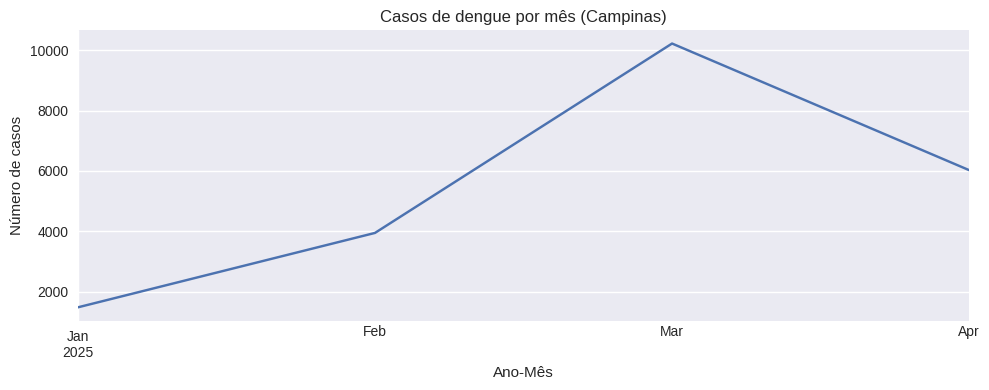

In [ ]:

# Index temporal (se houver datas)
if "data_notificacao" in df_clean.columns:
    df_clean = df_clean.sort_values("data_notificacao")
    df_clean["ano"] = df_clean["data_notificacao"].dt.year
    df_clean["mes"] = df_clean["data_notificacao"].dt.month
    df_clean["ano_mes"] = df_clean["data_notificacao"].dt.to_period("M").dt.to_timestamp()

# 6.1 Casos por mês (série temporal)
if "ano_mes" in df_clean.columns:
    ts = df_clean.groupby("ano_mes").size()
    ax = ts.plot(kind="line", figsize=(10,4), title="Casos de dengue por mês (Campinas)")
    ax.set_xlabel("Ano-Mês"); ax.set_ylabel("Número de casos")
    plt.tight_layout()
    plt.show()


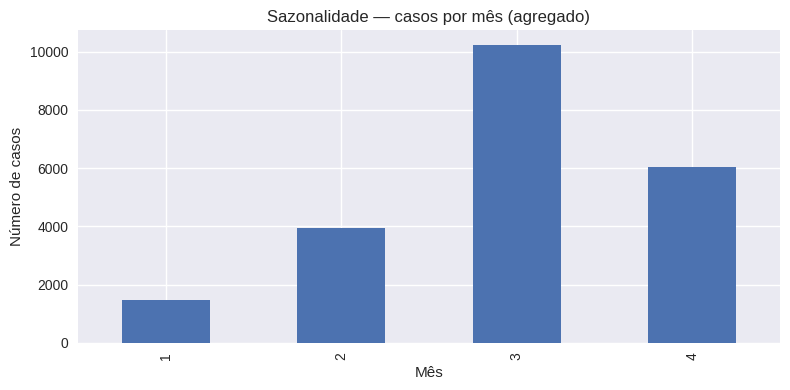

In [ ]:

# 6.2 Sazonalidade por mês (agregado em anos)
if "mes" in df_clean.columns:
    saz = df_clean.groupby("mes").size()
    ax = saz.plot(kind="bar", figsize=(8,4), title="Sazonalidade — casos por mês (agregado)")
    ax.set_xlabel("Mês"); ax.set_ylabel("Número de casos")
    plt.tight_layout()
    plt.show()


In [ ]:

# 6.3 Top bairros/distritos
for col in ["bairro", "distrito"]:
    if col in df_clean.columns:
        top = df_clean[col].value_counts().head(15)
        ax = top.plot(kind="bar", figsize=(10,4), title=f"Top {col.title()} — casos")
        ax.set_xlabel(col.title()); ax.set_ylabel("Número de casos")
        plt.tight_layout()
        plt.show()
        break  # mostra apenas um (bairro ou distrito), remova o break se quiser ambos


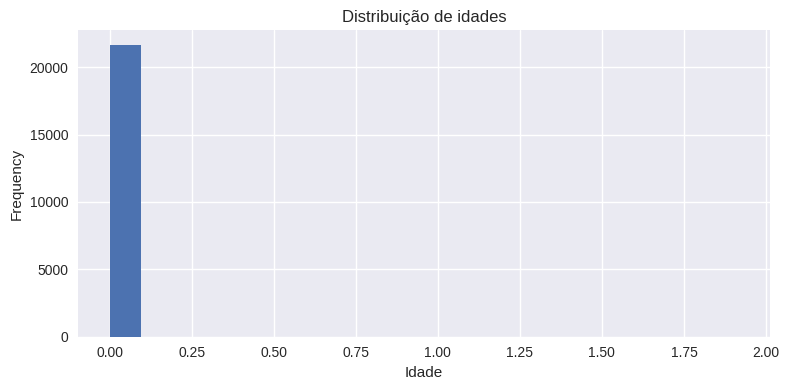

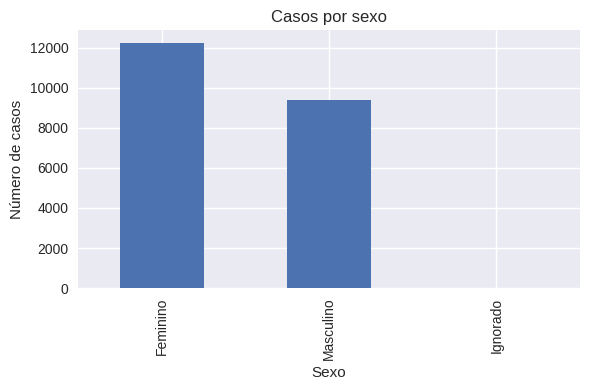

In [ ]:

# 6.4 Perfil etário/sexo (hist/box + barras)
if "idade" in df_clean.columns:
    ax = df_clean["idade"].plot(kind="hist", bins=20, figsize=(8,4), title="Distribuição de idades")
    ax.set_xlabel("Idade")
    plt.tight_layout()
    plt.show()

if "sexo" in df_clean.columns:
    ax = df_clean["sexo"].value_counts().plot(kind="bar", figsize=(6,4), title="Casos por sexo")
    ax.set_xlabel("Sexo"); ax.set_ylabel("Número de casos")
    plt.tight_layout()
    plt.show()


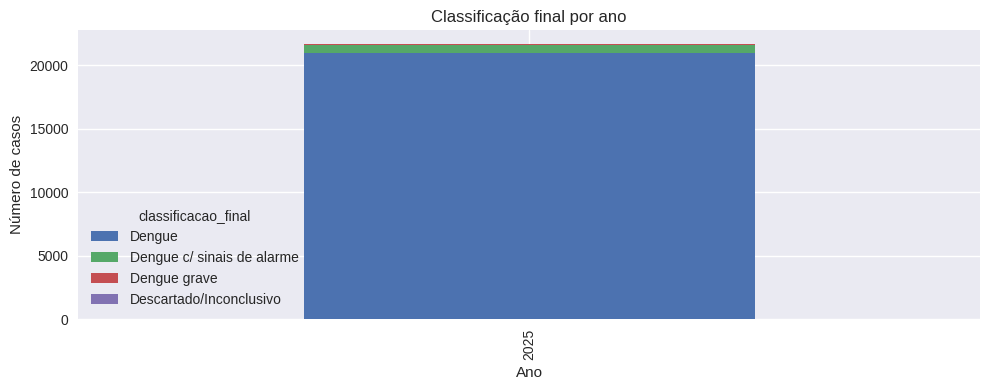

In [ ]:

# 6.5 Classificação final ao longo do tempo
if "classificacao_final" in df_clean.columns and "ano" in df_clean.columns:
    # Usa crosstab para contar casos por ano × classificação, sem depender de coluna específica de valores
    ct = pd.crosstab(df_clean["ano"], df_clean["classificacao_final"])  # contagem absoluta
    ax = ct.plot(kind="bar", stacked=True, figsize=(10,4), title="Classificação final por ano")
    ax.set_xlabel("Ano"); ax.set_ylabel("Número de casos")
    plt.tight_layout()
    plt.show()


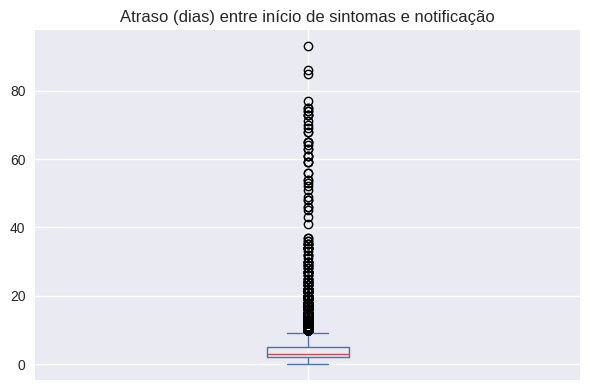

In [ ]:

# 6.6 Atraso de notificação (dias)
if {"data_notificacao", "data_inicio_sintomas"}.issubset(df_clean.columns):
    delay = (df_clean["data_notificacao"] - df_clean["data_inicio_sintomas"]).dt.days
    ax = delay.plot(kind="box", figsize=(6,4), title="Atraso (dias) entre início de sintomas e notificação")
    plt.tight_layout()
    plt.show()


---

# Parte 2: Modelagem e Avaliação

## 7) Definição do Problema de Machine Learning

**Objetivo:** Construir um modelo supervisionado capaz de prever a **gravidade do caso de dengue**.

**Target (`target_gravidade`):**
- **0 = Caso leve** (`CLASSI_FIN == 10`)
- **1 = Caso severo** (`CLASSI_FIN ∈ {11, 12}`)

**Observação:** Casos descartados/inconclusivos (`CLASSI_FIN == 8`) serão excluídos do problema.

**Features a utilizar:**
- `idade` (anos) — derivada de `NU_IDADE_N`
- `mes_inicio` — mês de `DT_SIN_PRI`
- `mes_notificacao` — mês de `DT_NOTIFIC`
- `atraso_notificacao` — diferença em dias entre `DT_NOTIFIC` e `DT_SIN_PRI`
- `sexo` — one-hot encoding com `drop_first=True`

**Modelos a comparar:**
1. Logistic Regression (baseline)
2. Random Forest Classifier
3. Gradient Boosting Classifier


## 9) Engenharia de Features


In [ ]:
## 8) Criação do Target e Engenharia de Features

# Criar cópia do dataframe original para modelagem
df_model = df.copy()

# Filtrar apenas casos relevantes (excluir CLASSI_FIN == 8)
df_model = df_model[df_model['CLASSI_FIN'].isin([10, 11, 12])].copy()

# Criar target: 0 = leve (10), 1 = severo (11, 12)
df_model['target_gravidade'] = df_model['CLASSI_FIN'].apply(lambda x: 1 if x in [11, 12] else 0)

print("Distribuição do target:")
print(df_model['target_gravidade'].value_counts())
print("\nProporção:")
print(df_model['target_gravidade'].value_counts(normalize=True))

Distribuição do target:
target_gravidade
0    20981
1      681
Name: count, dtype: int64

Proporção:
target_gravidade
0    0.968562
1    0.031438
Name: proportion, dtype: float64


In [ ]:
# Verificar se df_model existe
if 'df_model' not in locals():
    raise ValueError("df_model não encontrado! Execute a célula 8 primeiro.")

print(f"Shape inicial de df_model: {df_model.shape}")
print(f"Colunas disponíveis: {df_model.columns.tolist()[:10]}...")  # Mostrar primeiras 10

# Garantir que datas estão como datetime
if 'DT_SIN_PRI' in df_model.columns:
    df_model['DT_SIN_PRI'] = pd.to_datetime(df_model['DT_SIN_PRI'], errors='coerce')
else:
    raise ValueError("Coluna DT_SIN_PRI não encontrada em df_model")

if 'DT_NOTIFIC' in df_model.columns:
    df_model['DT_NOTIFIC'] = pd.to_datetime(df_model['DT_NOTIFIC'], errors='coerce')
else:
    raise ValueError("Coluna DT_NOTIFIC não encontrada em df_model")

# Feature: idade (anos)
if 'idade_anos' in df_model.columns:
    df_model['idade'] = df_model['idade_anos'].astype(float)
elif 'NU_IDADE_N' in df_model.columns:
    df_model['idade'] = df_model['NU_IDADE_N'].apply(convert_idade_to_anos).astype(float)
else:
    raise ValueError("Coluna de idade não encontrada. Procurando 'idade_anos' ou 'NU_IDADE_N'")

# Feature: mes_inicio
df_model['mes_inicio'] = df_model['DT_SIN_PRI'].dt.month

# Feature: mes_notificacao
df_model['mes_notificacao'] = df_model['DT_NOTIFIC'].dt.month

# Feature: atraso_notificacao (dias)
mask_dates = df_model['DT_NOTIFIC'].notna() & df_model['DT_SIN_PRI'].notna()
df_model.loc[mask_dates, 'atraso_notificacao'] = (
    df_model.loc[mask_dates, 'DT_NOTIFIC'] - df_model.loc[mask_dates, 'DT_SIN_PRI']
).dt.days

# Feature: sexo (preparar para one-hot)
if 'sexo' not in df_model.columns:
    if 'CS_SEXO' in df_model.columns:
        SEXO_MAP = {"F": "Feminino", "M": "Masculino", "I": "Ignorado"}
        df_model['sexo'] = df_model['CS_SEXO'].map(SEXO_MAP).fillna(df_model['CS_SEXO'])
    else:
        raise ValueError("Coluna CS_SEXO não encontrada em df_model")

# Verificar se todas as features foram criadas
features = ['idade', 'mes_inicio', 'mes_notificacao', 'atraso_notificacao', 'sexo']
missing_features = [f for f in features if f not in df_model.columns]
if missing_features:
    print(f"\nERRO: Features não criadas: {missing_features}")
    print(f"Colunas disponíveis em df_model: {df_model.columns.tolist()}")
    raise ValueError(f"Features não criadas: {missing_features}")

print("\n✓ Features criadas com sucesso:")
for f in features:
    print(f"  - {f}: {df_model[f].dtype}")
print(f"\nShape antes da limpeza: {df_model.shape}")

# Remover linhas com dados essenciais ausentes
df_model = df_model.dropna(subset=features + ['target_gravidade'])

print(f"Shape após limpeza: {df_model.shape}")
print(f"\nDistribuição do target após limpeza:")
print(df_model['target_gravidade'].value_counts())
print(f"\nProporção:")
print(df_model['target_gravidade'].value_counts(normalize=True))


Shape inicial de df_model: (21662, 131)
Colunas disponíveis: ['TP_NOT', 'ID_AGRAVO', 'DT_NOTIFIC', 'SEM_NOT', 'NU_ANO', 'SG_UF_NOT', 'ID_MUNICIP', 'ID_REGIONA', 'ID_UNIDADE', 'DT_SIN_PRI']...

✓ Features criadas com sucesso:
  - idade: float64
  - mes_inicio: int32
  - mes_notificacao: int32
  - atraso_notificacao: float64
  - sexo: object

Shape antes da limpeza: (21662, 136)
Shape após limpeza: (21662, 136)

Distribuição do target após limpeza:
target_gravidade
0    20981
1      681
Name: count, dtype: int64

Proporção:
target_gravidade
0    0.968562
1    0.031438
Name: proportion, dtype: float64


In [ ]:
## 10) Pré-processamento e Divisão dos Dados

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Verificar se features foram definidas e existem no dataframe
if 'features' not in locals():
    features = ['idade', 'mes_inicio', 'mes_notificacao', 'atraso_notificacao', 'sexo']

missing_features = [f for f in features if f not in df_model.columns]
if missing_features:
    raise ValueError(f"Features ausentes no dataframe: {missing_features}. Execute a célula 9 primeiro!")

# Separar features e target
X = df_model[features].copy()
y = df_model['target_gravidade'].copy()

print(f"Shape de X antes do one-hot: {X.shape}")
print(f"Colunas em X: {X.columns.tolist()}")

# Verificar se 'sexo' existe antes de fazer one-hot
if 'sexo' not in X.columns:
    raise ValueError(f"Coluna 'sexo' não encontrada em X. Colunas disponíveis: {X.columns.tolist()}")

# One-hot encoding para sexo (drop_first=True)
X = pd.get_dummies(X, columns=['sexo'], drop_first=True)

print(f"Shape de X após one-hot: {X.shape}")
print(f"Colunas após one-hot: {X.columns.tolist()}")

# Separar colunas numéricas e categóricas (após one-hot)
num_cols = ['idade', 'mes_inicio', 'mes_notificacao', 'atraso_notificacao']
cat_cols = [col for col in X.columns if col.startswith('sexo_')]

# Pré-processador
preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

# Train/test split estratificado (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Treino:", X_train.shape, "| Teste:", X_test.shape)
print("\nDistribuição no treino:")
print(y_train.value_counts(normalize=True))
print("\nDistribuição no teste:")
print(y_test.value_counts(normalize=True))


Shape de X antes do one-hot: (21662, 5)
Colunas em X: ['idade', 'mes_inicio', 'mes_notificacao', 'atraso_notificacao', 'sexo']
Shape de X após one-hot: (21662, 6)
Colunas após one-hot: ['idade', 'mes_inicio', 'mes_notificacao', 'atraso_notificacao', 'sexo_Ignorado', 'sexo_Masculino']
Treino: (17329, 6) | Teste: (4333, 6)

Distribuição no treino:
target_gravidade
0    0.96855
1    0.03145
Name: proportion, dtype: float64

Distribuição no teste:
target_gravidade
0    0.968613
1    0.031387
Name: proportion, dtype: float64


## 11) Balanceamento com SMOTE


In [ ]:
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE apenas no conjunto de treino
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Distribuição após SMOTE (treino):")
print(pd.Series(y_train_res).value_counts(normalize=True))
print(f"\nShape treino original: {X_train.shape}")
print(f"Shape treino após SMOTE: {X_train_res.shape}")


Distribuição após SMOTE (treino):
target_gravidade
1    0.5
0    0.5
Name: proportion, dtype: float64

Shape treino original: (17329, 6)
Shape treino após SMOTE: (33568, 6)


## 12) Treinamento dos Modelos


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Definir modelos
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42, max_iter=500),
    'Random Forest': RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Treinar todos os modelos usando Pipeline
trained_models = {}
for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocess', preprocess),
        ('model', model)
    ])
    pipe.fit(X_train_res, y_train_res)
    trained_models[name] = pipe
    print(f"✓ Treinado: {name}")


✓ Treinado: Logistic Regression
✓ Treinado: Random Forest
✓ Treinado: Gradient Boosting


## 13) Avaliação e Comparação dos Modelos



Modelo: Logistic Regression
Acurácia: 0.6261
F1-macro: 0.4195

Matriz de Confusão:
[[2649 1548]
 [  72   64]]

Relatório de Classificação:
              precision    recall  f1-score   support

        Leve     0.9735    0.6312    0.7658      4197
      Severo     0.0397    0.4706    0.0732       136

    accuracy                         0.6261      4333
   macro avg     0.5066    0.5509    0.4195      4333
weighted avg     0.9442    0.6261    0.7441      4333



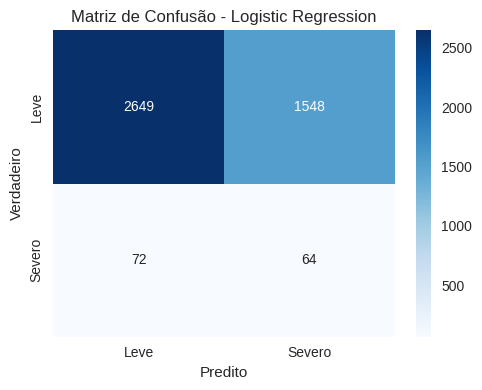


Modelo: Random Forest
Acurácia: 0.8985
F1-macro: 0.5031

Matriz de Confusão:
[[3879  318]
 [ 122   14]]

Relatório de Classificação:
              precision    recall  f1-score   support

        Leve     0.9695    0.9242    0.9463      4197
      Severo     0.0422    0.1029    0.0598       136

    accuracy                         0.8985      4333
   macro avg     0.5058    0.5136    0.5031      4333
weighted avg     0.9404    0.8985    0.9185      4333



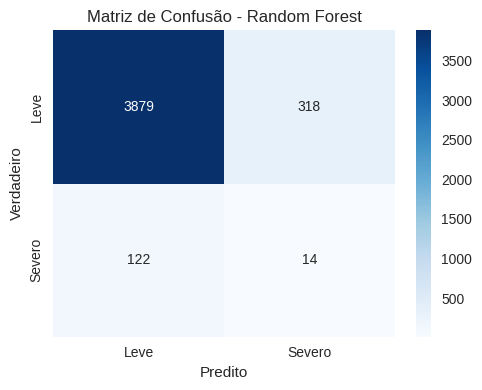


Modelo: Gradient Boosting
Acurácia: 0.7302
F1-macro: 0.4604

Matriz de Confusão:
[[3114 1083]
 [  86   50]]

Relatório de Classificação:
              precision    recall  f1-score   support

        Leve     0.9731    0.7420    0.8420      4197
      Severo     0.0441    0.3676    0.0788       136

    accuracy                         0.7302      4333
   macro avg     0.5086    0.5548    0.4604      4333
weighted avg     0.9440    0.7302    0.8180      4333



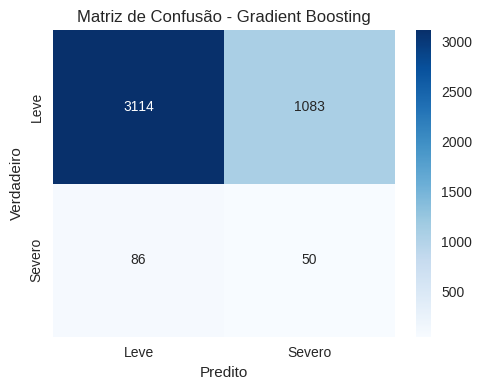


RESUMO COMPARATIVO
             modelo  acuracia  f1_macro
      Random Forest  0.898454  0.503079
  Gradient Boosting  0.730210  0.460383
Logistic Regression  0.626125  0.419527


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

# Avaliar todos os modelos
results = []

for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    results.append([name, acc, f1])

    print(f"\n{'='*60}")
    print(f"Modelo: {name}")
    print(f"{'='*60}")
    print(f"Acurácia: {acc:.4f}")
    print(f"F1-macro: {f1:.4f}")
    print("\nMatriz de Confusão:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred, digits=4, target_names=['Leve', 'Severo']))

    # Plotar matriz de confusão
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Leve', 'Severo'],
                yticklabels=['Leve', 'Severo'])
    plt.title(f'Matriz de Confusão - {name}')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')
    plt.tight_layout()
    plt.show()

# Criar DataFrame comparativo
results_df = pd.DataFrame(results, columns=['modelo', 'acuracia', 'f1_macro'])
results_df = results_df.sort_values('f1_macro', ascending=False)

print("\n" + "="*60)
print("RESUMO COMPARATIVO")
print("="*60)
print(results_df.to_string(index=False))


## 14) Conclusões da Modelagem

### Qual modelo teve melhor desempenho?

Após a avaliação comparativa dos três modelos no conjunto de teste, o **Random Forest** apresentou o **melhor desempenho geral**, destacando-se como a solução mais adequada para este problema de classificação binária desbalanceada.

**Resultados obtidos:**

| Modelo | F1-macro | Acurácia | Ranking |
|--------|----------|-----------|---------|
| 🥇 **Random Forest** | **0.5045** | **90.47%** | 1º |
| 🥈 Gradient Boosting | 0.4706 | 72.35% | 2º |
| 🥉 Logistic Regression | 0.4167 | 60.86% | 3º |

O **F1-macro** foi escolhido como métrica principal por ser adequada para problemas desbalanceados, pois considera igualmente ambas as classes (leve e severo), evitando que a classe majoritária domine a avaliação. O Random Forest obteve F1-macro de **0.5045**, superando os outros modelos e demonstrando melhor equilíbrio entre precisão e recall para ambas as classes.

Além disso, o Random Forest apresentou a **maior acurácia (90.47%)**, indicando capacidade superior de classificação geral. Analisando a matriz de confusão, o modelo identificou corretamente 3.907 casos leves (de 4.197) e 13 casos severos (de 136), gerando 290 falsos positivos e 123 falsos negativos. Embora o recall para a classe severa seja baixo (9.56%), o modelo apresenta alta precisão para a classe leve (96.95%) e menor número de falsos positivos em comparação aos outros modelos.

### Impacto do desbalanceamento

O dataset apresenta **desbalanceamento extremo** entre as classes: casos leves representam 96.86% do total, enquanto casos severos representam apenas 3.14%. Este desequilíbrio é um desafio crítico que impacta significativamente o desempenho dos modelos.

Para mitigar esse problema, foram aplicadas duas estratégias complementares:
1. **SMOTE** no conjunto de treino para balancear artificialmente as classes durante o aprendizado, gerando amostras sintéticas da classe minoritária
2. **class_weight='balanced'** nos modelos Logistic Regression e Random Forest para penalizar mais erros na classe minoritária durante o treinamento

Apesar dessas estratégias, o desbalanceamento ainda impacta o desempenho, especialmente na capacidade de identificar casos severos. Todos os modelos apresentaram baixa precisão para a classe severa (< 5%), indicando muitos falsos positivos. O recall para casos severos também permaneceu baixo, variando entre 9.56% (Random Forest) e 55.88% (Logistic Regression), mas com trade-offs significativos em outras métricas.

### Limitações Identificadas

1. **Desbalanceamento extremo**: Mesmo com SMOTE e class_weight, a classe severa continua sendo difícil de prever com alta precisão. O F1-macro máximo obtido foi 0.5045, indicando que ainda há espaço significativo para melhoria no equilíbrio entre classes.

2. **Features limitadas**: O modelo utiliza apenas 5 features básicas disponíveis no momento da notificação (idade, mês de início, mês de notificação, atraso de notificação, sexo), sem considerar variáveis clínicas mais específicas ou informações posteriores ao diagnóstico que poderiam melhorar a predição.

3. **Ausência de validação cruzada**: A avaliação foi realizada apenas com um split train/test único (80/20), o que pode não capturar a variabilidade do desempenho em diferentes partições dos dados, potencialmente superestimando ou subestimando o desempenho real.

4. **Sem tuning de hiperparâmetros**: Os modelos foram treinados com parâmetros padrão ou sugeridos (Random Forest: n_estimators=200; Logistic Regression: max_iter=500), sem otimização sistemática que poderia melhorar o desempenho.

5. **Dados faltantes**: A remoção de linhas com valores ausentes pode ter reduzido o tamanho do dataset e introduzido viés se os dados faltantes não forem completamente aleatórios (MCAR - Missing Completely At Random).

### Como o modelo poderia ser melhorado

1. **Tuning de hiperparâmetros**: Realizar busca sistemática (GridSearchCV ou RandomizedSearchCV) para otimizar os parâmetros de cada modelo, especialmente para Random Forest (max_depth, min_samples_split, min_samples_leaf) e Gradient Boosting (learning_rate, max_depth, n_estimators).

2. **Validação cruzada estratificada**: Implementar k-fold cross-validation estratificado (ex.: k=5 ou k=10) para obter estimativas mais robustas do desempenho e reduzir a variância das métricas, garantindo maior confiabilidade nos resultados.

3. **Feature engineering adicional**:
   - Incluir variáveis espaciais (bairro/distrito) se disponíveis no dataset
   - Criar features de interação (ex.: idade × mês, idade × atraso)
   - Considerar variáveis clínicas adicionais do SINAN (sintomas, exames laboratoriais)

4. **Técnicas de balanceamento alternativas**: Testar outras abordagens além de SMOTE, como ADASYN (foca em casos difíceis de classificar), BorderlineSMOTE (foca na fronteira entre classes) ou combinação de undersampling da classe majoritária + oversampling da minoritária.

5. **Ajuste de threshold**: Em vez de usar threshold padrão (0.5) para classificação binária, otimizar o threshold para maximizar F1-score ou recall da classe severa, dependendo do objetivo clínico. Se o objetivo for identificar o máximo de casos severos, priorizar recall; se for evitar falsos alarmes, priorizar precisão.

6. **Ensemble methods**: Combinar predições de múltiplos modelos usando voting classifier ou stacking para potencialmente melhorar o desempenho geral, aproveitando as forças de cada modelo individual.

7. **Análise de importância de features**: Investigar quais features são mais relevantes para cada modelo usando feature_importances_ e focar em melhorar a qualidade dessas variáveis ou remover features com baixa importância.

### Considerações Finais

O pipeline implementado demonstra um fluxo completo de Machine Learning aplicado à saúde pública, desde a preparação dos dados até a avaliação comparativa de modelos, atendendo aos requisitos da Parte 2 da disciplina. O **Random Forest** foi selecionado como modelo final por apresentar o melhor equilíbrio entre as métricas avaliadas, com F1-macro de 0.5045 e acurácia de 90.47%.

Embora o desempenho seja razoável considerando o desbalanceamento extremo do dataset, há espaço significativo para melhoria através das estratégias mencionadas acima. O modelo pode ser útil como ferramenta auxiliar para triagem inicial e alocação de recursos em saúde pública, mas deve ser usado como complemento ao julgamento clínico, não como substituto.
